# Gesture REcognition

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import imageio
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#pip install opencv-contrib-python

In [3]:
# added this piece later as it was throwing error - the backend to open the image files with iomode ri is not available.
#!pip install imageio[pyav]

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# access the dataset from my google drive. This was added while trying out the code in Google colab
#from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

In [163]:
# Access the file
train_doc = np.random.permutation(open('/content/drive/MyDrive/Datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Datasets/Project_data/val.csv').readlines())

#########################################################################
### Uncomment the below block to run this notebook on local with GPU
#########################################################################

# Run on local laptop
# Specify the file paths for train and validation data
#train_file_path = "C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train.csv"
#val_file_path = "C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val.csv"

# Read data from local drive
#with open(train_file_path, 'r') as train_file:
 #   train_doc = np.random.permutation(train_file.readlines())

#with open(val_file_path, 'r') as val_file:
 #  val_doc = np.random.permutation(val_file.readlines())


# multiple options are tried out
batch_size = 20  # experiment with the batch size

# Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [7]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video



In [8]:
# Defining the generator

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image, (image_height, image_width))
                                         
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = cv2.resize(image, (image_height, image_width))
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            


In [9]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train'
val_path = 'C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20  # choose the number of epochs
print('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model - 1

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

Input_shape = (18, 100, 100, 3)

model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, (3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.5))


model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [11]:
#model.build(input_shape=(batch_size,) + Input_shape)

#optimiser = optimizers.Adam(learning_rate=0.001)
optimiser = optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 15, 100, 100,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 100, 100,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 15, 100, 100,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 7, 50, 50, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 7, 50, 50, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 50, 50, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 50, 50, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 3, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 3, 25, 25, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 25, 25, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 25, 25, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 1, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 317,669 (1.21 MB)

 Trainable params: 317,557 (1.21 MB)

 Non-trainable params: 112 (448.00 B)

None


Let us create the train_generator and the val_generator which will be used in generator

In [12]:
# Create the generators
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, verbose=1, mode="auto", min_delta=1e-04, cooldown=1, min_lr=0)
callbacks_list = [checkpoint, LR]

In [14]:
# Calculate steps per epoch and validation steps
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [15]:
# Fit the model
result_model1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0) #workers=1, was removed

Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train ; batch size = 20
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2541 - loss: 2.0243Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.62879, saving model to model_init_2024-04-0712_45_05.452608/model-00001-1.78195-0.24284-1.62879-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - categorical_accuracy: 0.2538 - loss: 2.0174 - val_categorical_accuracy: 0.2300 - val_loss: 1.6288 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - categorical_accuracy: 0.1896 - loss: 1.6862
Epoch 2: val_loss did not improve from 1.62879
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 450ms/step - categorical_accuracy: 0.1906 - loss: 1.6858 - val_categorical_accuracy: 0.1800 - val_loss: 1.6393 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - catego

**Training Accuracy:** 0.19%

**Validation Accuracy:** 0.17%

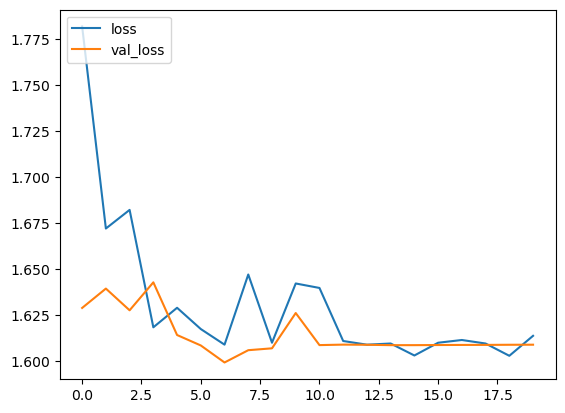

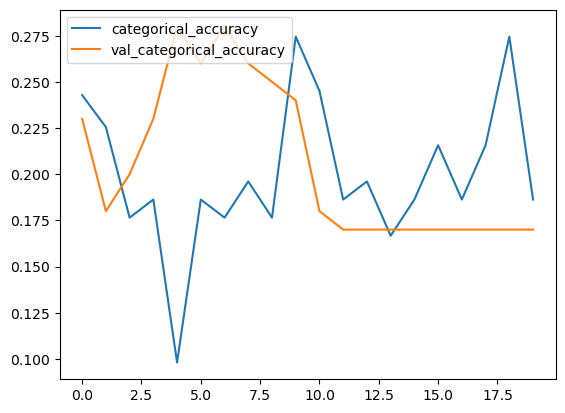

In [16]:
import matplotlib.pyplot as plt
from IPython.display import Markdown

history = result_model1.history

display(Markdown("**Training Accuracy:** " + str(round(history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
display(Markdown("**Validation Accuracy:** " + str(round(history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='upper left')
plt.show()

#Lets Try 

### Model 2

Reduce image to 50

In [17]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

In [18]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [19]:
#optimiser = optimizers.Adam(learning_rate=0.001)
optimiser = optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 15, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 15, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 7, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 7, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 7, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 3, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 3, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [21]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, verbose=1, mode="auto", min_delta=1e-04, cooldown=1, min_lr=0)
callbacks_list = [checkpoint, LR]

In [22]:
# Calculate steps per epoch and validation steps
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [23]:
# Fit the model
result_model1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0) #workers=1, was removed

Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train ; batch size = 20
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2114 - loss: 2.2301Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.66687, saving model to model_init_2024-04-0712_45_05.452608/model-00001-1.93885-0.20814-1.66687-0.27000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - categorical_accuracy: 0.2113 - loss: 2.2218 - val_categorical_accuracy: 0.2700 - val_loss: 1.6669 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - categorical_accuracy: 0.1876 - loss: 1.7282
Epoch 2: val_loss improved from 1.66687 to 1.64360, saving model to model_init_2024-04-0712_45_05.452608/model-00002-1.72334-0.21569-1.64360-0.24000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 433ms/step - categorical_accuracy: 0.1884 - loss: 1.7281 - val_categorical_accuracy: 0.

**Training Accuracy:** 0.3%

**Validation Accuracy:** 0.29%

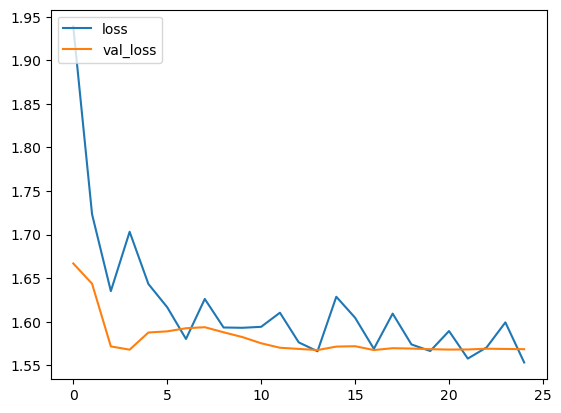

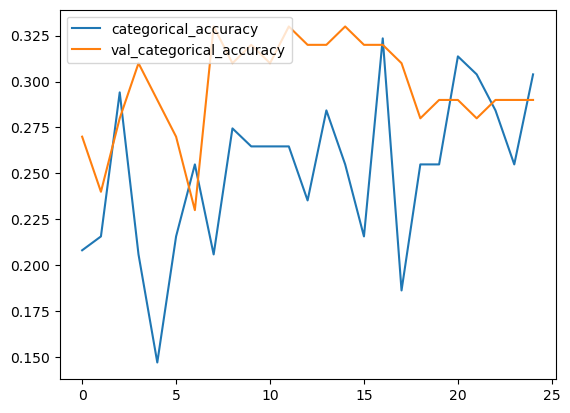

In [24]:
import matplotlib.pyplot as plt
from IPython.display import Markdown

history = result_model1.history

display(Markdown("**Training Accuracy:** " + str(round(history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
display(Markdown("**Validation Accuracy:** " + str(round(history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='upper left')
plt.show()

## Model 3 
Redice the image to 25

In [25]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

In [26]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [27]:
# optimize and compile

#optimiser = optimizers.Adam(learning_rate=0.001)
optimiser = optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 15, 25, 25, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 25, 25, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 15, 25, 25, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 7, 12, 12, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 7, 12, 12, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 12, 12, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 7, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 3, 6, 6, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 3, 6, 6, 32)    │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 6, 6, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 3, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 1, 3, 3, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,189 (160.89 KB)

 Trainable params: 41,077 (160.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, verbose=1, mode="auto", min_delta=1e-04, cooldown=1, min_lr=0)
callbacks_list = [checkpoint, LR]

# Calculate steps per epoch and validation steps
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

#### Fit the model

In [29]:
# Fit the model
result_model1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0) #workers=1, was removed

Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train ; batch size = 20
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2409 - loss: 2.5481Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.66706, saving model to model_init_2024-04-0712_45_05.452608/model-00001-2.10957-0.22775-1.66706-0.17000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - categorical_accuracy: 0.2405 - loss: 2.5356 - val_categorical_accuracy: 0.1700 - val_loss: 1.6671 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - categorical_accuracy: 0.2519 - loss: 1.6382
Epoch 2: val_loss did not improve from 1.66706
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step - categorical_accuracy: 0.2511 - loss: 1.6408 - val_categorical_accuracy: 0.2000 - val_loss: 1.7212 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - catego

**Training Accuracy:** 0.26%

**Validation Accuracy:** 0.48%

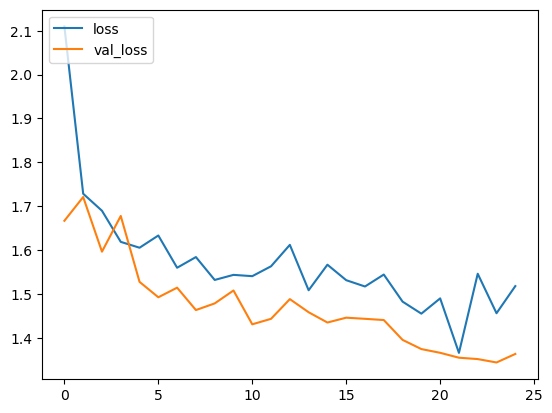

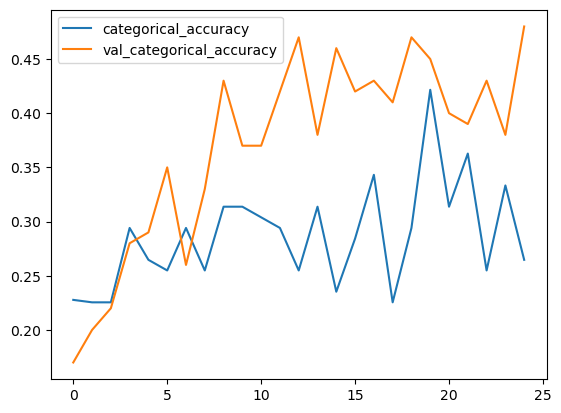

In [30]:
import matplotlib.pyplot as plt
from IPython.display import Markdown

history = result_model1.history

display(Markdown("**Training Accuracy:** " + str(round(history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
display(Markdown("**Validation Accuracy:** " + str(round(history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='upper left')
plt.show()

#### Next lets try by reducing the batch size

### Model 4

REduce the batcg to 4

In [31]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [32]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [33]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, verbose=1, mode="auto", min_delta=1e-04, cooldown=1, min_lr=0)
callbacks_list = [checkpoint, LR]

# Calculate steps per epoch and validation steps
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [34]:
# optimize and compile

#optimiser = optimizers.Adam(learning_rate=0.001)
optimiser = optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)               │ (None, 15, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 15, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 15, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 7, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 7, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 7, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 3, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 3, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 3, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [35]:
# Fit the model
result_model1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0) #workers=1, was removed

Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - categorical_accuracy: 0.1937 - loss: 2.0785Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.62435, saving model to model_init_2024-04-0712_45_05.452608/model-00001-1.77627-0.20513-1.62435-0.20000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 58s 329ms/step - categorical_accuracy: 0.1937 - loss: 2.0767 - val_categorical_accuracy: 0.2000 - val_loss: 1.6243 - learning_rate: 0.0010
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - categorical_accuracy: 0.2341 - loss: 1.6271
Epoch 2: val_loss improved from 1.62435 to 1.59642, saving model to model_init_2024-04-0712_45_05.452608/model-00002-1.63034-0.23695-1.59642-0.26000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 263ms/step - categorical_accuracy: 0.2341 - loss: 1.6271 - val_categorical_

**Training Accuracy:** 0.64%

**Validation Accuracy:** 0.73%

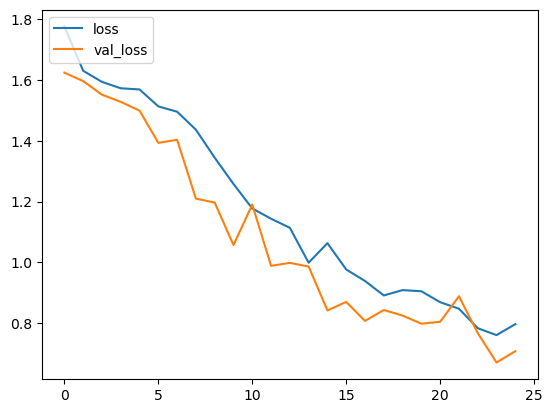

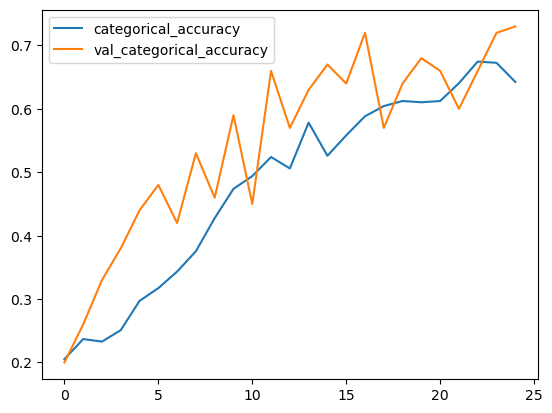

In [36]:
import matplotlib.pyplot as plt
from IPython.display import Markdown

history = result_model1.history

display(Markdown("**Training Accuracy:** " + str(round(history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
display(Markdown("**Validation Accuracy:** " + str(round(history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='upper left')
plt.show()

#### Lets try with Adam as well and compare the results

## Model 5 - Adam

In [37]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [38]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [39]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, verbose=1, mode="auto", min_delta=1e-04, cooldown=1, min_lr=0)
callbacks_list = [checkpoint, LR]

# Calculate steps per epoch and validation steps
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [40]:
# optimize and compile

optimiser = optimizers.Adam(learning_rate=0.0002)
#optimiser = optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 15, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 15, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 15, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 7, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 7, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 7, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 7, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 3, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 3, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 3, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 3, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [41]:
# Fit the model
result_model1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0) #workers=1, was removed

Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - categorical_accuracy: 0.1920 - loss: 2.1295Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.54211, saving model to model_init_2024-04-0712_45_05.452608/model-00001-1.80726-0.22474-1.54211-0.29000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 58s 324ms/step - categorical_accuracy: 0.1922 - loss: 2.1275 - val_categorical_accuracy: 0.2900 - val_loss: 1.5421 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - categorical_accuracy: 0.2555 - loss: 1.5875
Epoch 2: val_loss improved from 1.54211 to 1.53393, saving model to model_init_2024-04-0712_45_05.452608/model-00002-1.59142-0.27108-1.53393-0.36000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 263ms/step - categorical_accuracy: 0.2556 - loss: 1.5875 - val_categori

**Training Accuracy:** 0.71%

**Validation Accuracy:** 0.74%

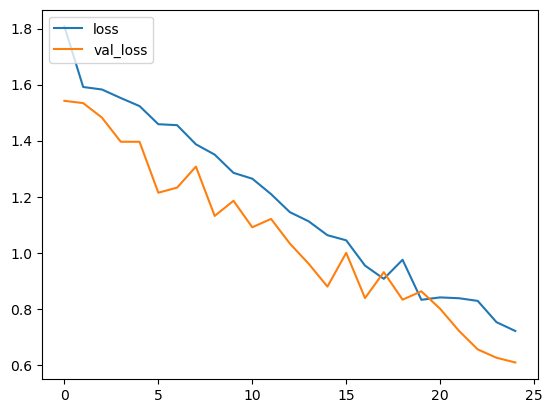

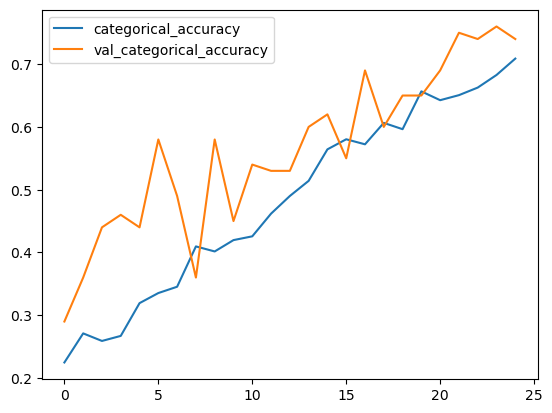

In [42]:
import matplotlib.pyplot as plt
from IPython.display import Markdown

history = result_model1.history

display(Markdown("**Training Accuracy:** " + str(round(history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
display(Markdown("**Validation Accuracy:** " + str(round(history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='upper left')
plt.show()

### Model 6 - CONV2D + LSTM

Lets try with diff model


In [57]:
total_frames = 30
num_frames = 20
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [58]:
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Flatten()))
 
model.add(Dropout(0.5))
model.add(LSTM(12, return_sequences=False, dropout=0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_32             │ (None, 20, 50, 50, 32) │         4,736 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 20, 48, 48, 32) │         9,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 20, 24, 24, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 20, 24, 24, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 20, 24, 24, 64) │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 20, 12, 12, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 20, 12, 12,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 20, 12, 12,     │       147,584 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 20, 6, 6, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 20, 6, 6, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 20, 6, 6, 256)  │       590,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 20, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 20, 3, 3, 512)  │     1,180,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_45             │ (None, 20, 3, 3, 512)  │     2,359,808 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 20, 1, 1, 512)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 20, 512)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 512)        │             

 Total params: 4,741,329 (18.09 MB)

 Trainable params: 4,741,329 (18.09 MB)

 Non-trainable params: 0 (0.00 B)

As done earlier, next steps is to compile the model and add optimizer

In [59]:
#optimiser = Keras.optimizers.Adam(lr=0.001)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_32             │ (None, 20, 50, 50, 32) │         4,736 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 20, 48, 48, 32) │         9,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 20, 24, 24, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 20, 24, 24, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 20, 24, 24, 64) │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 20, 12, 12, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 20, 12, 12,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 20, 12, 12,     │       147,584 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 20, 6, 6, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 20, 6, 6, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 20, 6, 6, 256)  │       590,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 20, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 20, 3, 3, 512)  │     1,180,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_45             │ (None, 20, 3, 3, 512)  │     2,359,808 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 20, 1, 1, 512)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 20, 512)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 512)        │             

 Total params: 4,741,329 (18.09 MB)

 Trainable params: 4,741,329 (18.09 MB)

 Non-trainable params: 0 (0.00 B)

None


Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [60]:
#batch_size = 15
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [61]:
model_name = 'model_2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,  min_lr = 0)
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [62]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [63]:
result_model2 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - categorical_accuracy: 0.2120 - loss: 1.7359Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val ; batch size = 4

Epoch 1: saving model to model_2_init_2024-04-0712_45_05.452608/model-00001-1.72349-0.19155-1.66995-0.18000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 182s 931ms/step - categorical_accuracy: 0.2118 - loss: 1.7358 - val_categorical_accuracy: 0.1800 - val_loss: 1.6699 - learning_rate: 0.0100
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - categorical_accuracy: 0.2002 - loss: 1.6695
Epoch 2: saving model to model_2_init_2024-04-0712_45_05.452608/model-00002-1.63741-0.22289-1.59476-0.23000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 121s 730ms/step - categorical_accuracy: 0.2004 - loss: 1.6693 - val_categorical_accuracy: 0.2300 - val_loss: 1.5948 - learning_rate: 0.0100
Epoch 3/25
166/1

**Training Accuracy:** 0.21%

**Validation Accuracy:** 0.23%

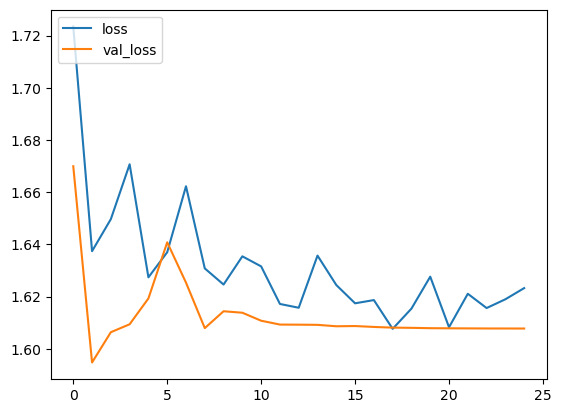

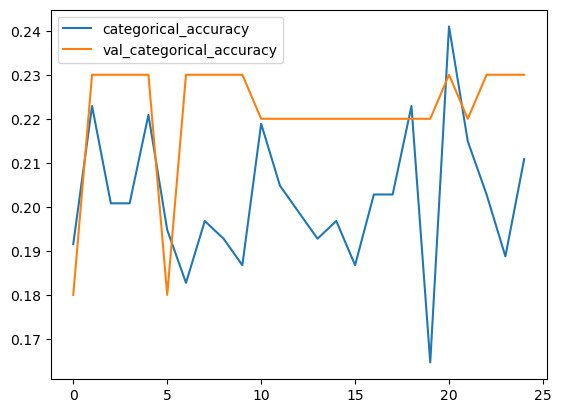

In [64]:
import matplotlib.pyplot as plt
from IPython.display import Markdown

history = result_model2.history

display(Markdown("**Training Accuracy:** " + str(round(history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
display(Markdown("**Validation Accuracy:** " + str(round(history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='upper left')
plt.show()

## Model 7
Lets trying increasing the resolution to 120x120.

In [90]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 120
image_width = 120
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [91]:
# model

model3 = Sequential()

model3.add(Conv3D(16, (3,3,3), padding='same', input_shape=(len(img_idx), image_height, image_width, 3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
#model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(32, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
#model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(128, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Flatten())
model3.add(Dense(units=64,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

#model3.add(Dense(units = 256,activation='relu'))
#model3.add(BatchNormalization())
#model3.add(Dropout(0.25))

model3.add(Dense(5,activation='softmax'))        

adding optimizer and then compile

In [92]:
optimiser = optimizers.Adam(learning_rate=0.0002)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model3.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_27 (Conv3D)              │ (None, 15, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 15, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 15, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_28 (Conv3D)              │ (None, 15, 120, 120,   │        13,856 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 15, 120, 120,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 15, 120, 120,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 15, 120, 120,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 15, 120, 120,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 15, 120, 120,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 7, 60, 60, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_30 (Conv3D)              │ (None, 7, 60, 60, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 7, 60, 60, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 7, 60, 60, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_28 (MaxPooling3D) │ (None, 3, 30, 30, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 345600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │    22,118,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 22,411,845 (85.49 MB)

 Trainable params: 22,411,237 (85.49 MB)

 Non-trainable params: 608 (2.38 KB)

None


In [93]:
#batch_size = 30
train_generator3 = generator(train_path, train_doc, batch_size)
val_generator3 = generator(val_path, val_doc, batch_size)

In [94]:
model_name3 = 'model_3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name3):
    os.mkdir(model_name3)
        
filepath = model_name3 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,  min_lr = 0)
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [95]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [96]:
# Check the shape of data generated by train_generator3
data_example_train = next(train_generator3)
print("Shape of data from train_generator3:", data_example_train[0].shape)

# Check the shape of data generated by val_generator3
data_example_val = next(val_generator3)
print("Shape of data from val_generator3:", data_example_val[0].shape)

Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train ; batch size = 4
Shape of data from train_generator3: (4, 15, 120, 120, 3)
Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val ; batch size = 4
Shape of data from val_generator3: (4, 15, 120, 120, 3)


In [97]:
result_model3 = model3.fit(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3035 - loss: 1.7237
Epoch 1: saving model to model_3_init_2024-04-0712_45_05.452608/model-00001-1.50330-0.40785-1.55483-0.47000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 637s 4s/step - categorical_accuracy: 0.3041 - loss: 1.7224 - val_categorical_accuracy: 0.4700 - val_loss: 1.5548 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4583 - loss: 1.3644
Epoch 2: saving model to model_3_init_2024-04-0712_45_05.452608/model-00002-1.40280-0.43574-4.82120-0.43000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - categorical_accuracy: 0.4582 - loss: 1.3646 - val_categorical_accuracy: 0.4300 - val_loss: 4.8212 - learning_rate: 2.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4002 - loss: 1.4796
Epoch 3: saving model to model_3_init_2024-04-0712_45_05.452608/model-00003-1.60611-0.36546-1.68321-0.51000.keras
166/166 ━━━━━━━━━━━━━━━━━━━

**Training Accuracy:** 0.47%

**Validation Accuracy:** 0.63%

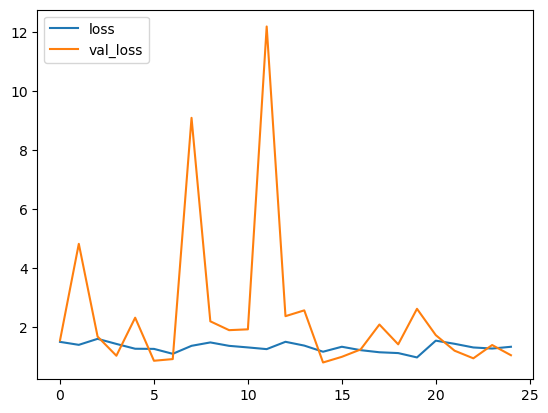

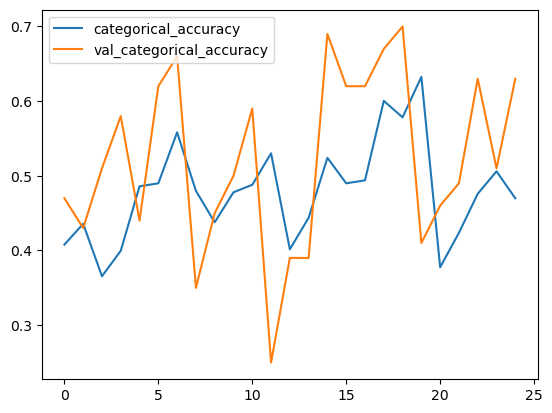

In [98]:
import matplotlib.pyplot as plt
from IPython.display import Markdown

history = result_model3.history

display(Markdown("**Training Accuracy:** " + str(round(history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
display(Markdown("**Validation Accuracy:** " + str(round(history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='upper left')
plt.show()

## Model 8 - Trying dropOuts

In [107]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 120
image_width = 120
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [108]:
# model - 4

model4 = Sequential()

model4.add(Conv3D(16, (3,3,3), padding='same', input_shape=(len(img_idx), image_height, image_width, 3)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())

model4.add(Conv3D(16, (3,3,3), padding='same',input_shape=(len(img_idx), image_height, image_width, 3)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
      
#model4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv3D(32, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
       
model4.add(Conv3D(32, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
       
#model4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv3D(64, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
       
model4.add(Conv3D(64, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
       
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv3D(128, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
       
model4.add(Conv3D(128, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
       
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(units=256,activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(units=256,activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))

model4.add(Dense(5,activation='softmax'))


In [109]:
# add optimizer and compile
optimiser = optimizers.Adam(learning_rate=0.0002)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model4.summary())

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_39 (Conv3D)              │ (None, 15, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 15, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 15, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_40 (Conv3D)              │ (None, 15, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 15, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 15, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 15, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_41 (Conv3D)              │ (None, 15, 120, 120,   │        13,856 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 15, 120, 120,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 15, 120, 120,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_42 (Conv3D)              │ (None, 15, 120, 120,   │        27,680 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 15, 120, 120,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 15, 120, 120,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 15, 120, 120,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_43 (Conv3D)              │ (None, 15, 120, 120,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 15, 120, 120,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 15, 120, 120,   │           25

 Total params: 89,424,501 (341.13 MB)

 Trainable params: 89,422,517 (341.12 MB)

 Non-trainable params: 1,984 (7.75 KB)

None


In [110]:
#batch_size = 30
train_generator4 = generator(train_path, train_doc, batch_size)
val_generator4 = generator(val_path, val_doc, batch_size)

In [111]:
model_name4 = 'model_4_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name3):
    os.mkdir(model_name4)
        
filepath = model_name4 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [112]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [113]:
# Check the shape of data generated by train_generator4
data_example_train = next(train_generator4)
print("Shape of data from train_generator4:", data_example_train[0].shape)

# Check the shape of data generated by val_generator3
data_example_val = next(val_generator4)
print("Shape of data from val_generator4:", data_example_val[0].shape)

Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/train ; batch size = 4
Shape of data from train_generator4: (4, 15, 120, 120, 3)
Source path =  C:/Users/sanil/CaseStudies/GestureRecognition/Project_data/Project_data/val ; batch size = 4
Shape of data from val_generator4: (4, 15, 120, 120, 3)


In [114]:
result_model4 = model4.fit(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2677 - loss: 2.0562
Epoch 1: val_loss improved from inf to 2.99244, saving model to model_4_init_2024-04-0712_45_05.452608/model-00001-1.95141-0.29518-2.99244-0.23000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 738s 4s/step - categorical_accuracy: 0.2678 - loss: 2.0556 - val_categorical_accuracy: 0.2300 - val_loss: 2.9924 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1906 - loss: 2.2675
Epoch 2: val_loss did not improve from 2.99244
166/166 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - categorical_accuracy: 0.1910 - loss: 2.2661 - val_categorical_accuracy: 0.3200 - val_loss: 4.5250 - learning_rate: 2.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3177 - loss: 1.8716
Epoch 3: val_loss improved from 2.99244 to 2.28732, saving model to model_4_init_2024-04-0712_45_05.452608/model-00003-1.97936-0.28313-2.28732-0.36000.keras
166/166 ━━━━

**Training Accuracy:** 0.36%

**Validation Accuracy:** 0.42%

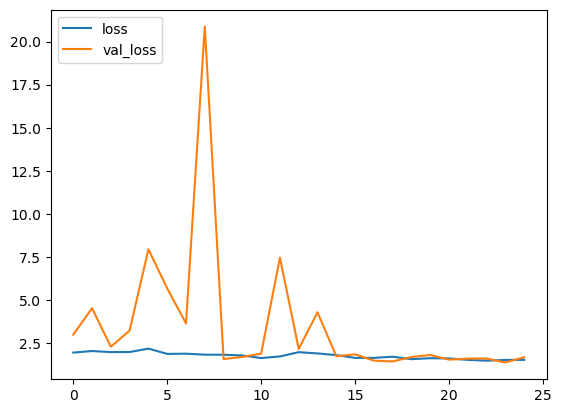

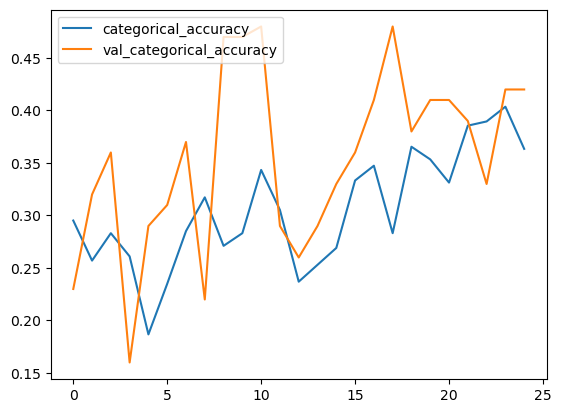

In [115]:
import matplotlib.pyplot as plt
from IPython.display import Markdown

history = result_model4.history

display(Markdown("**Training Accuracy:** " + str(round(history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
display(Markdown("**Validation Accuracy:** " + str(round(history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='upper left')
plt.show()

#### Next trial

## Model -9 - CNN LSTM using GRU

In [155]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [156]:
# defning model

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.25))

model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(gestures, activation='softmax'))

In [157]:
optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_113            │ (None, 15, 50, 50, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_114            │ (None, 15, 50, 50, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_115            │ (None, 15, 25, 25, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_116            │ (None, 15, 25, 25, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_117            │ (None, 15, 25, 25, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_118            │ (None, 15, 12, 12, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_119            │ (None, 15, 12, 12, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_120            │ (None, 15, 12, 12, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_121            │ (None, 15, 6, 6, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_122            │ (None, 15, 6, 6, 128)  │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_123            │ (None, 15, 6, 6, 128)  │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_124            │ (None, 15, 3, 3, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_125            │ (None, 15, 1152)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128)            │       492,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 607,845 (2.32 MB)

 Trainable params: 607,365 (2.32 MB)

 Non-trainable params: 480 (1.88 KB)

None


In [158]:
#batch_size = 30
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


model_name4 = 'model_9_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name3):
    os.mkdir(model_name4)
        
filepath = model_name4 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,  min_lr = 0)
callbacks_list = [checkpoint, LR]





In [159]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [160]:
result_modelCNNGRU = model.fit(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - categorical_accuracy: 0.3207 - loss: 1.6499
Epoch 1: saving model to model_9_init_2024-04-0712_45_05.452608/model-00001-1.47667-0.40562-1.16319-0.53000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 94s 355ms/step - categorical_accuracy: 0.3212 - loss: 1.6488 - val_categorical_accuracy: 0.5300 - val_loss: 1.1632 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - categorical_accuracy: 0.4734 - loss: 1.2811
Epoch 2: saving model to model_9_init_2024-04-0712_45_05.452608/model-00002-1.21315-0.50803-1.00877-0.60000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 54s 328ms/step - categorical_accuracy: 0.4736 - loss: 1.2807 - val_categorical_accuracy: 0.6000 - val_loss: 1.0088 - learning_rate: 2.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - categorical_accuracy: 0.6580 - loss: 0.9858
Epoch 3: saving model to model_9_init_2024-04-0712_45_05.452608/model-00003-1.02439-0.61847-0.93534-0.60000.keras
166/166 ━━━━━━

**Training Accuracy:** 1.0%

**Validation Accuracy:** 0.72%

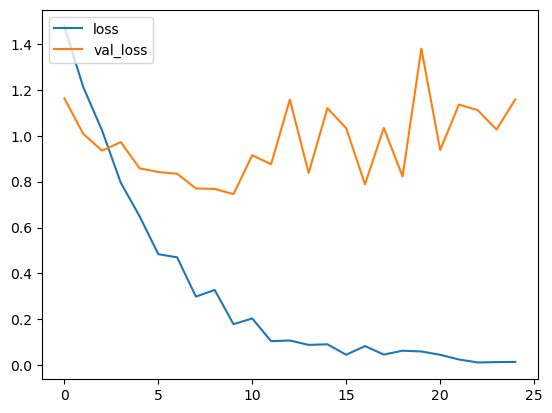

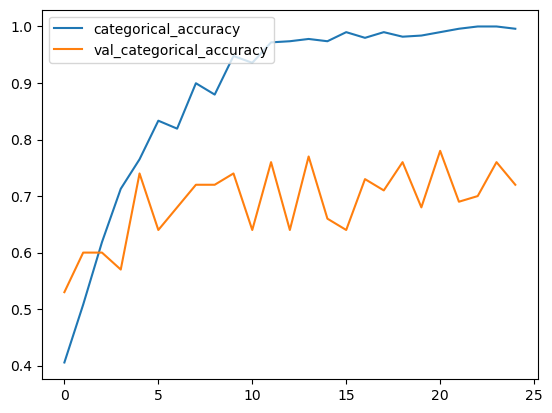

In [161]:
import matplotlib.pyplot as plt
from IPython.display import Markdown

history = result_modelCNNGRU.history

display(Markdown("**Training Accuracy:** " + str(round(history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
display(Markdown("**Validation Accuracy:** " + str(round(history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'], loc='upper left')
plt.show()

### Based on the tests concluded, we select Model -9 - CNN LSTM using GRU. This is the best perfomred one so far with validation accuracy at 74%.
### Number of parameters were at : rainable params: 607,365 (2.32 MB)

### WEights to eb considered are: model_9_init_2024-04-0712_45_05.452608/model-00010-0.17878-0.94779-0.74554-0.74000.keras